In [60]:
import torch
from torch import nn,optim
from torch.nn import init            #包含了很多初始化方法

#引入初始化相关的内容
from  seqInit import toTs
from  seqInit import input_size
from seqInit import train,real         #train dim为120，real（验证集）dim为144，只拿了前120个数据训练，看能不能预测后面24个数据

import numpy as np
import matplotlib.pyplot as plt

print(train.shape,real.shape)

(120, 1) (144, 1)


In [68]:
#定义RNN 模型
class rnnModel(nn.Module):
    def __init__(self,in_dim,hidden_dim,out_dim,layer_num):
        super().__init__()
        self.rnn=nn.RNN(in_dim,hidden_dim,layer_num,batch_first=True)
        self.fc=nn.Linear(hidden_dim,out_dim)
        optim_range=np.sqrt(1.0/hidden_dim)
        self.weightInit(optim_range)

    def forward(self, x):  # x dim: (batch,time_step,input_size)
        out,_=self.rnn(x)
        out=out[:,12:,:]       # 由于这里，最终把input的(1，119,1)变成了输出的（1，107,1），由第1~ N的数预训练，训练目的是逼近第13~ N的数
        out=self.fc(out)
        return  out

    def weightInit(self,gain=1):
        #使用初始化模型参数
        for name ,param in self.named_parameters():        # self.named_parameters()是nn.Module的参数，给出了网络的名字和参数
            if 'rnn.weight' in name:                       
                init.orthogonal(param,gain)                # 正交初始化，使得tensor是正交的

In [73]:
#输入维度1，输出维度1 ，隐藏层10，定义rnn层数2
rnn=rnnModel(1,10,1,2)

#确定损失函数和优化函数
criterion=nn.MSELoss()
optimizer=optim.Adam(rnn.parameters(),lr=1e-2)

# 处理输入
def create_dataset(dataset) :
    data = dataset.reshape(1, -1, 1)
    return torch.from_numpy(data)

trainX = create_dataset(train[:-1])   #train[:-1]是(119,1)，最后trainX是（1,119,1），由第1~119的数当trainX
trainY = create_dataset(train[1:])[:,12:,:]  #train[1:]是(119,1)，最后trainY是（1,107,1），由第14~120的数当trainY，与trainX错位表示有滞后性


# 训练RNN模型
frq, sec = 2000, 200
loss_set = []
for e in range(1, frq + 1) :
    inputs = trainX
    target = trainY
    # forward
    output = rnn(inputs)
    loss = criterion(output, target)
    # update gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # print training information
    print_loss = loss.item()
    loss_set.append((e, print_loss))
    if e % sec == 0 :
        print('Epoch[{}/{}], loss = {:.5f}'.format(e, frq, print_loss))

D:\anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:20: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.


Epoch[200/2000], loss = 0.00338
Epoch[400/2000], loss = 0.00238
Epoch[600/2000], loss = 0.00221
Epoch[800/2000], loss = 0.00242
Epoch[1000/2000], loss = 0.00194
Epoch[1200/2000], loss = 0.00188
Epoch[1400/2000], loss = 0.00178
Epoch[1600/2000], loss = 0.00150
Epoch[1800/2000], loss = 0.00119
Epoch[2000/2000], loss = 0.00114


In [76]:
# 测试
rnn = rnn.eval()
px = real[:-1].reshape(1, -1, 1)            # dim （143,1,1），拿第1~143的数据来做预测输入，经过rnn之后变成了14~144的预测结果
px = torch.from_numpy(px)
ry = real[1:].reshape(-1)                   # dim  (144,),第2~144的真实结果
py = rnn(px).data                           
py = np.array(py).reshape(-1)               # dim （131,），会得到第14~144的预测结果
print(px.shape,ry.shape,py.shape)

torch.Size([1, 143, 1]) (143,) (131,)


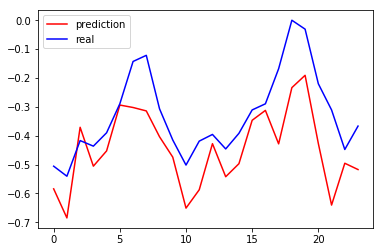

In [77]:
# 画出实际结果和预测的结果
plt.plot(py[-24:], 'r', label='prediction')
plt.plot(ry[-24:], 'b', label='real')
plt.legend(loc='best')

In [18]:
# 注意，发现其中有一个数据没有用来训练和预测，是因为：
# 0,1...118是trainX，13,14....119是trainY，trainX经过rnn之后，数据变成了12,13...118，发现跟trainY错位了一位，这样才能训练未来的预测